# 5 Filters

To filter signals on graphs, we need to define filters. They are represented in the toolbox by the [`pygsp.filters.Filter` class](https://pygsp.readthedocs.io/en/stable/reference/filters.html). Filters are usually defined in the spectral domain. Given the transfer function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, utils
from additional_utils import get_approx_filter
import time

## 5.1 Heat diffusion

The heat kernel $h(\lambda)$ is defined as:
$$h_\tau(\lambda)=\exp^{-\tau\lambda}.$$
In fact, the graph heat equation reads (see section 2.5.5. of *Discrete Calculus* (by Grady and Polimeni)):
$$\frac{d\mathbf{x}}{dt}+\mathbf{Lx} = \mathbf{0}.$$
In the Fourier space, this translates in:
$$\frac{d\hat{\mathbf{x}}}{dt}+\mathbf{\Lambda}\hat{\mathbf{x}} = \mathbf{0},$$
where $\hat{\mathbf{x}}=\mathbf{U}^\top\mathbf{x}$ is the Fourier transform of $\mathbf{x}$. This equation is easily solved in each dimension by the exponential with:
$$\hat{\mathbf{x}} = \exp^{-t\mathbf{\Lambda}}\hat{\mathbf{x}_0}$$
where $\hat{x_0}$ is the initial signal at time $t=0$. Such that:
$$\mathbf{x}(t) =\mathbf{U} \exp^{-t\mathbf{\Lambda}}\mathbf{U}^\top \mathbf{x}_0=\mathbf{U} h_t(\mathbf{\Lambda})\mathbf{U}^\top \mathbf{x}_0.$$


In [ ]:
G1 = graphs.Sensor(seed=42)
G1.compute_fourier_basis()
G2 = graphs.Ring(N=100)
G2.compute_fourier_basis()
G2.set_coordinates('line1D')

TAUS = [0, 5, 100]
DELTA = 10

fig, axes = plt.subplots(len(TAUS), 3, figsize=(15, 6))

for i, tau in enumerate(TAUS):
    g1 = filters.Heat(G1, tau)
    g2 = filters.Heat(G2, tau)
    
    y = g1.localize(DELTA).squeeze()
    G1.plot_signal(y, ax=axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].text(0, -0.2, '$y^T L y = {:.2f}$'.format(y.T @ G1.L @ y))
    
    G2.plot_signal(g2.localize(G2.N//2), ax=axes[i, 2])
    
    g1.plot(ax=axes[i, 1])
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')
    text = r'$\hat{{g}}(\lambda) = \exp \left( \frac{{-{{{}}} \lambda}}{{\lambda_{{max}}}} \right)$'.format(tau)
    axes[i, 1].text(6, 0.5, text, fontsize=15)
    
axes[0, 0].set_title('$y = \hat{{g}}(L) \delta_{{{}}}$: localized on sensor'.format(DELTA))
axes[0, 1].set_title('$\hat{g}(\lambda)$: filter defined in the spectral domain')
axes[0, 2].set_title('$y = \hat{{g}}(L) \delta_{{{}}}$: localized on ring graph'.format(G2.N//2))
axes[-1, 1].set_xlabel("$\lambda$: laplacian's eigenvalues / graph frequencies")

## 5.2 Exercise

Solve the following problem using a graph filter:
$$\mathbf{x}^* = \operatorname*{arg\,min}_{\mathbf{x} \in \mathbb{R}^N} \|\mathbf{y} - \mathbf{x}\|_2^2 + \alpha \mathbf{x}^\intercal \mathbf{L} \mathbf{x},$$
where $y$ is the observed signal, $\alpha$ is an hyper-parameter which controls the trade-off between the data fidelity term and the smoothness prior.

In [ ]:
# your code here

## 5.3 Example of denoising
Let's define a low-pass filter
$$g(\lambda) = \frac{1}{1+\tau\lambda}$$
Given a noisy version of a smooth signal $x_\text{noisy}$, one can denoise it with the low-pass filter $g$:
$$ x_\text{denoised} = \mathbf{U}g(\mathbf{\Lambda})\mathbf{U}^\top x_{\text{noisy}}$$

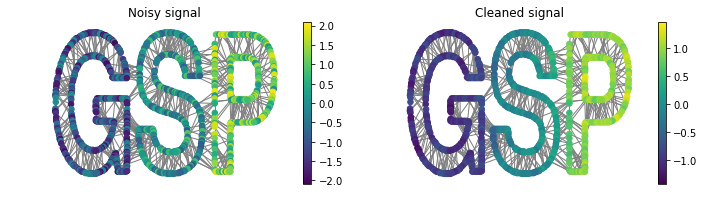

In [2]:
# the graph:
G = graphs.Logo()
G.compute_fourier_basis()

# the filter:
tau = 1
def g(x):
    return 1. / (1. + tau * x)
g = filters.Filter(G, g)

# the noisy signal:
x = np.zeros(G.N)
x[G.info['idx_g']-1] = -1
x[G.info['idx_s']-1] = 0
x[G.info['idx_p']-1] = 1
rs = np.random.RandomState(42)
x_noisy = x + rs.uniform(-1, 1, size=G.N)

# the denoised signal:
x_denoised = g.filter(x_noisy, method='exact')

# and... plot:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
G.plot_signal(x_noisy, vertex_size=30, ax=axes[0])
_ = axes[0].set_title('Noisy signal')
axes[0].set_axis_off()
G.plot_signal(x_denoised, vertex_size=30, ax=axes[1])
_ = axes[1].set_title('Cleaned signal')
axes[1].set_axis_off()
fig.tight_layout()

## 5.4 Polynomial approximation
Let us approximate the filter $$g(x) = \frac{1}{1+x}$$ on the interval $[0,\lambda_N]$ by a Chebychev polynomial of order $m$:
$$g(x) \simeq \sum_{k=0}^m \alpha_k x^k=p(x),$$
such that the exact filtering can be approximated by a polynomial in $\mathbf{L}$:
\begin{align}
x_{\text{filtered}}&=\mathbf{U}g(\mathbf{\Lambda})\mathbf{U}^\top x\\
&\simeq \mathbf{U}p(\mathbf{\Lambda})\mathbf{U}^\top x\\
&=\mathbf{U}\sum_{k=0}^m \alpha_k \mathbf{\Lambda}^k\mathbf{U}^\top x\\
&=\sum_{k=0}^m \alpha_k \mathbf{L}^k x
\end{align}
Note that computing $\sum_{k=0}^m \alpha_k \mathbf{L}^k x$ takes only $m$ matrix-vector multiplication and costs thus $\mathcal{O}(m|E|)$ with $|E|$ the number of edges of the graph (compared to the $\mathcal{O}(N^3)$ necessary operations just to diagonalize $\mathbf{L}$ for the exact computation!)

In [ ]:
m=2

In [ ]:
g = lambda x: 1 / (1 + x)
filt_g = filters.Filter(G, g)
c = filters.approximations.compute_cheby_coeff(filt_g, m=m)

In [ ]:
filt_approx = get_approx_filter(c)

x = np.arange(0, G.lmax, (G.lmax) / 1000)
plt.figure()
plt.plot(x, g(x))
plt.hold
plt.plot(x, np.squeeze(filt_approx((x-(G.lmax/2)) / (G.lmax/2))))
plt.legend(['original filter', 'polynomial approximation'])

In [ ]:
start_time = time.time()
G.compute_fourier_basis(recompute = True) #just to measure time
x_denoised_exact = filt_g.filter(x_noisy, method='exact')
time_exact_filter = time.time() - start_time
start_time = time.time()
G.estimate_lmax(recompute = True) #just to measure time
x_denoised_cheby = filt_g.filter(x_noisy, method='chebyshev', order=m)
time_cheby_filter = time.time() - start_time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
G.plot_signal(x_denoised_exact, vertex_size=30, ax=axes[0])
_ = axes[0].set_title('Exact denoising')
axes[0].set_axis_off()
G.plot_signal(x_denoised_cheby, vertex_size=30, ax=axes[1])
_ = axes[1].set_title('Chebyshev approx')
axes[1].set_axis_off()
fig.tight_layout()

In [ ]:
print('The max error is ' + str(np.max(np.abs(x_denoised_exact-x_denoised_cheby))))
print('The mean energy of the error is ' + str((np.sum((x_denoised_exact - x_denoised_cheby)**2)/G.N)))

print('The computation time for exact filtering was ' + str(time_exact_filter))
print('The computation time for approx filtering was ' + str(time_cheby_filter))

### Exercise: Precision-Efficiency trade-off of the polynomial approximation
Illustrate the precision vs computation time trade-off of the Chebyshev polynomial approximation, as the order of the polynomial changes. How about with the ideal low-pass```g = lambda x: x <= cut_off_freq```?

## 5.5 Spectral Graph Wavelets
Given a (smooth-enough) bandpass filter $g(u)$, a wavelet centered on node $i$ at scale $s\geq0$ reads:
$$\mathbf{\psi}_{s,i} = \mathbf{U}g(s\mathbf{\Lambda})\mathbf{U}^\top \mathbf{\delta}_i\in\mathbb{R}^{N},$$ 
where $\mathbf{\delta}_i\in\mathbb{R}^N$ is the Dirac centered on node $i$: $\mathbf{\delta}_i(i)=1$ and $0$ elsewhere. See the [seminal paper](https://hal.inria.fr/file/index/docid/541855/filename/hammond-vandergheynst-gribonval-acha-2009r.pdf) by Hammond et al. for details on spectral graph wavelets. Given a graph signal $\mathbf{x}$, the wavelet coefficient at node $i$ and scale $s$, denoted by $W_{s,i}(\mathbf{x})$, is the projection of the signal on $\mathbf{\psi}_{s,i}$:
$$W_{s,i}(\mathbf{x}) = \mathbf{\psi}_{s,i}^\top\mathbf{x}\in\mathbb{R}.$$

Let us consider $\mathcal{S}=(s_1, s_2, \ldots, s_m)$ a set of $m$ scales. The collection of $m$ filters $\{g(s_1 u), g(s_2 u), \ldots, g(s_m u)\}$ is called a *filterbank*. Consider all wavelet coefficients $\{W_{s,i}\}_{s\in\mathcal{S},~i\in\mathcal{V}}$ of a graph signal $\mathbf{x}$. Can we recover perfectly $\mathbf{x}$ from its wavelet coefficients? The answer is "no" because wavelet filters are necessarily bandpass (thus $g(0)=0$) and constant signals are in the null space of the transform!

Let us add a low-pass $h(u)$ to the filterbank for instance (the exact form does not have a huge importance):
$$h(u)=\exp^{-u^4}.$$

Do the coefficients extracted from the combination of filters $(h(u), g(s_1 u), g(s_2 u), \ldots, g(s_m u))$ enough for perfect reconstruction of any $\mathbb{R}^N$ signal?

**Theorem.** (see Theorem 5.6 of [Hammond et al.](https://hal.inria.fr/file/index/docid/541855/filename/hammond-vandergheynst-gribonval-acha-2009r.pdf)) Perfect recovery is possible iff 
$$\text{min}_{u\in\{\lambda_0, \ldots, \lambda_{N-1}\}} \quad h(u)^2 + \sum_{s\in\mathcal{S}} g(su)^2 > 0.$$

In [ ]:
G = graphs.Sensor(seed=42)
G.compute_fourier_basis()

In [ ]:
# The mexican hat bandpass example
mex_hat = lambda x: x * np.exp(-x) 
plt.plot(np.arange(0,10,0.01), mex_hat(np.arange(0,10,0.01)))

In [ ]:
m=5
g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)

In [ ]:
eval_x = np.arange(0, G.lmax, G.lmax/1000)
y = g.evaluate(eval_x)

In [ ]:
plt.plot(eval_x, y.T)
plt.plot(G.e, g.evaluate(G.e).T, '+')
plt.xlabel('$\lambda$')
plt.ylabel('filters')
plt.figure()
plt.plot(G.e, np.sum(np.power(g.evaluate(G.e).T,2),1), '+')
plt.ylim([0, 1])

As we see on the last graph, we have :
$$\text{min}_{u\in\{\lambda_0, \ldots, \lambda_{N-1}\}} \quad h(u)^2 + \sum_{s\in\mathcal{S}} g(su)^2 > 0.$$
Perfect reconstruction of all $\mathbb{R}^N$ signals is thus possible! The frame is not tight though.

**Plot a few wavelets**

In [ ]:
node = 10
delta_node = np.zeros((G.N,))
delta_node[node] = 1
wavelet_at_node = g.filter(delta_node)
wavelet_at_node.shape

In [ ]:
G.plot_signal(delta_node) # the delta signal centered on 'node'
G.plot_signal(wavelet_at_node[:,5]) # the wavelet centered on 'node' at very small scale (large value of s)
G.plot_signal(wavelet_at_node[:,4]) # the wavelet at the same node but at slightly larger scale (smaller value of s)
G.plot_signal(wavelet_at_node[:,3]) # etc.
G.plot_signal(wavelet_at_node[:,2])
G.plot_signal(wavelet_at_node[:,1])

**Example** Plot some wavelets in the SBM model. Observe how wavelets first "diffuse" within the blocks before exploring the whole network

**Filterbanks for compression :**
We are going to use the filterbanks 'Itersine' (which forms a tight frame). Some methods exist to 'tighten' the frame formed by the 'MexicanHat' for instance, but we will not look into this here.

In [ ]:
m=5
g = filters.Itersine(G, Nf = m + 1)
eval_x = np.arange(0, G.lmax, G.lmax/1000)
y = g.evaluate(eval_x)
plt.plot(eval_x, y.T)
plt.plot(G.e, g.evaluate(G.e).T, '+')
plt.xlabel('$\lambda$')
plt.ylabel('filters')
plt.figure()
plt.plot(G.e, np.sum(np.power(g.evaluate(G.e).T,2),1), '+')
plt.ylim([0, 1])

In [ ]:
comp_level = 0.9 #a scalar between 0 and 1, 0 meaning no compression

In [ ]:
x_toy_orig = - np.ones((G.N,))
ind_left = G.coords[:,0] < 0.5
x_toy_orig[ind_left] = 1
x_toy_noisy = x_toy_orig + 0.2 * np.random.randn(G.N)
G.plot_signal(x_toy_noisy)

In [ ]:
W_coeffs = g.filter(x_toy_noisy, method='exact')
n_coef = np.prod(W_coeffs.shape) # total number of scalars encoding the signal in the wavelet space
n_coef_comp = np.ceil((1 - comp_level) * n_coef).astype(int) # authorized number of scalars at specified compression level
 # find the threshold under which we will set entries to 0:
sorted_coefs = np.sort(np.abs(W_coeffs), axis=None) 
threshold = sorted_coefs[-n_coef_comp]
 # the thresholded wavelet transform:
W_coeffs_th = W_coeffs.copy()
W_coeffs_th[np.abs(W_coeffs) < threshold] = 0

In [ ]:
x_toy_recovered = g.synthesize(W_coeffs_th, method='exact')
G.plot_signal(x_toy_recovered)
print(str(np.linalg.norm(x_toy_recovered-x_toy_noisy)))

**Exercise** Plot the error of reconstruction vs the compression rate. 

This is only one quick example of compression. Denoising may be done as well, etc.